In [2]:
# import libraries
import multiprocessing as mp
import geopandas as gpd
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import polyline
from shapely import wkt
from warnings import warn
import math
import collections
from heapq import heappop, heappush
from itertools import count

/Users/kweon-youngseo/miniforge3/envs/ppd599/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/nh/bgd128891hxd7ggprg1zgbhm0000gn/T/ipykernel_2792/767327008.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Sha

In [3]:
# generate G of LA County
G = ox.graph_from_place('Los Angeles County, CA, USA', network_type='drive')

/Users/kweon-youngseo/miniforge3/envs/ppd599/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/kweon-youngseo/miniforge3/envs/ppd599/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/kweon-youngseo/miniforge3/envs/ppd599/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/kweon-youngseo/miniforge3/envs/ppd599/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/kweon-youngseo/miniforge3/envs/ppd599/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/kweon-youngseo/miniforge3/envs/ppd599/lib

In [4]:
# add attributes
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = ox.bearing.add_edge_bearings(G)

In [5]:
# create gdfs
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

In [6]:
# import O,D
origins_df = pd.read_csv("Data/origins_gdf.csv")
destinations_df = pd.read_csv("Data/destinations_gdf.csv")

origins_df['geometry'] = origins_df['geometry'].apply(wkt.loads)
destinations_df['geometry'] = destinations_df['geometry'].apply(wkt.loads)

# geodataframe of O, D
origins_gdf = gpd.GeoDataFrame(origins_df, geometry='geometry')
destinations_gdf = gpd.GeoDataFrame(destinations_df, geometry='geometry')

# Add attributes to G edges

In [ ]:
from Functions.add_edge import add_edge_traffic_times

In [9]:
G2 = add_edge_traffic_times(G, traffic_signals_time = 30, stop_time = 15, turning_circle_time = 5, crossing_time = 5, give_way_time = 5, mini_roundabout_time = 5)

In [10]:
# create gdfs
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G2)

In [11]:
edges_gdf

osmid   
u           v           key                                                    
653656      1718677597  0                                          159763316  \
            123189012   0    [1094670073, 1094670074, 1055876622, 383059215]   
            122697159   0     [1050285331, 1050285330, 399239123, 399239118]   
            1718756337  0                             [399258376, 399258374]   
653681      26427612    0                              [49287146, 149003055]   
...                                                                      ...   
10282698906 10282698902 0                                         1124470511   
10282698908 10282698899 0                                         1124470513   
10282727210 10282667848 0                                         1124470528   
10921172356 4103608485  0                                          408443245   
10994920986 325045085   0                                           29486469   

                                 lanes                       name   
u           v           key                                         
653656      1718677597  0            4       West Florence Avenue  \
            123189012   0    [5, 6, 4]  West Manchester Boulevard   
            122697159   0    [5, 6, 4]     West Manchester Avenue   
            1718756337  0       [5, 4]         Aviation Boulevard   
653681      26427612    0       [5, 6]          San Diego Freeway   
...                                ...                        ...   
10282698906 10282698902 0          NaN            Park Glen Court   
10282698908 10282698899 0          NaN            Park Glen Court   
10282727210 10282667848 0          NaN              Vintage Court   
10921172356 4103608485  0          NaN            Lady Linda Lane   
10994920986 325045085   0          NaN                        NaN   

                                 highway maxspeed  oneway reversed   length   
u           v           key                                                   
653656      1718677597  0      secondary   40 mph   False    False  253.852  \
            123189012   0        primary      NaN   False    False  159.909   
            122697159   0        primary      NaN   False     True  160.976   
            1718756337  0       tertiary      NaN   False    False  402.735   
653681      26427612    0       motorway   65 mph    True    False  252.266   
...                                  ...      ...     ...      ...      ...   
10282698906 10282698902 0    residential      NaN   False    False   79.545   
10282698908 10282698899 0    residential      NaN   False     True   65.442   
10282727210 10282667848 0    residential      NaN   False     True   40.961   
10921172356 4103608485  0    residential      NaN   False     True  190.290   
10994920986 325045085   0    residential      NaN   False     True   65.995   

                                                                      geometry   
u           v           key                                                      
653656      1718677597  0    LINESTRING (-118.37705 33.95990, -118.37705 33...  \
            123189012   0    LINESTRING (-118.37705 33.95990, -118.37695 33...   
            122697159   0    LINESTRING (-118.37705 33.95990, -118.37720 33...   
            1718756337  0    LINESTRING (-118.37705 33.95990, -118.37705 33...   
653681      26427612    0    LINESTRING (-118.40031 33.98940, -118.40087 33...   
...                                                                        ...   
10282698906 10282698902 0    LINESTRING (-118.64069 34.45947, -118.64075 34...   
10282698908 10282698899 0    LINESTRING (-118.63944 34.45851, -118.63982 34...   
10282727210 10282667848 0    LINESTRING (-118.63124 34.46071, -118.63157 34...   
10921172356 4103608485  0    LINESTRING (-118.54831 34.48244, -118.54838 34...   
10994920986 325045085   0    LINESTRING (-118.63838 34.47401, -118.63826 34...   

                             speed_kp

In [12]:
edges_gdf[['travel_time', 'traffic_time', 'total_time']]

travel_time  traffic_time  total_time
u           v           key                                       
653656      1718677597  0           14.2             0        14.2
            123189012   0            9.5             0         9.5
            122697159   0            9.5             0         9.5
            1718756337  0           29.4            30        59.4
653681      26427612    0            8.7             0         8.7
...                                  ...           ...         ...
10282698906 10282698902 0            7.1             0         7.1
10282698908 10282698899 0            5.8             0         5.8
10282727210 10282667848 0            3.6             0         3.6
10921172356 4103608485  0           16.9             0        16.9
10994920986 325045085   0            5.9             0         5.9

[461653 rows x 3 columns]

# Penalty functions

A penalty dictionary was created for input into the 'shortest_path_turn_penalty' function. Turns are defined based on the difference in the bearing of the edges. If the bearing of an edge falls between -150 and -25, it's treated as a left turn with a 30-second penalty. If between 25 and 150, it's treated as a right turn with a 10-second penalty. The 'shortest_path_turn_penalty' function interprets penalties in the format of (u,v,m), meaning the starting node, passing node, and destination node, so the dictionary was structured in that manner.

In [50]:
# # create empty penalty dictionary
# penalty = {}

# # iterate all nodes in G
# for v, data in G.nodes(data=True):
#     # for each previous node 'u' of node 'v'
#     for u, edge_keys in G.pred[v].items():
#         # for each edge from 'u' to 'v'
#         for key in edge_keys:
#             # for each next node 'm' of node 'v'
#             for m, next_edge_keys in G[v].items():
#                 # for each edge from 'v' to 'm'
#                 for next_key in next_edge_keys:
#                     # check both edges (u-v, v-m)
#                     if 'bearing' in G[u][v][key] and 'bearing' in G[v][m][next_key]:
#                         # calculate the difference between the bearings of the two edges
#                         bearing_diff = G[u][v][key]['bearing'] - G[v][m][next_key]['bearing']
#                         # add penlties based on the difference
#                         if -150 <= bearing_diff <= -25:
#                             penalty[(u, v, m)] = 30    # left turn
#                         elif 25 <= bearing_diff <= 150:
#                             penalty[(u, v, m)] = 10    # right turn
#                         else:
#                             penalty[(u, v, m)] = 0

To reproduce the results for future data, get_turn_penalty_dict function was created. Additional time was manually allocated as input to the function.

In [29]:
# Function of getting turn panelty dictionary

def get_turn_penalty_dict(G, left_turn_penalty = 30, right_turn_penalty = 10, u_turn_penalty = 90):
  penalty = {}
  # iterate all nodes in G
  for v, data in G.nodes(data=True):
    # for each previous node 'u' of node 'v'

    for u, edge_keys in G.pred[v].items():
      # for each edge from 'u' to 'v'
      for key in edge_keys:
        # for each next node 'm' of node 'v'
        for m, next_edge_keys in G[v].items():
          # for each edge from 'v' to 'm'
          for next_key in next_edge_keys:
            # check both edges (u-v, v-m)
            if 'bearing' in G[u][v][key] and 'bearing' in G[v][m][next_key]:
              # calculate the difference between the bearings of the two edges
              bearing_diff = (G[v][m][next_key]['bearing'] - G[u][v][key]['bearing']) % 360
               # add penlties based on the difference
              if  207 < bearing_diff <= 333:
                penalty[(u, v, m)] = 30    # left turn
              elif 27 < bearing_diff <= 153:
                penalty[(u, v, m)] = 10    # right turn
              elif 153 < bearing_diff <= 207:
                penalty[(u, v, m)] = 90    # U turn
              else:
                penalty[(u, v, m)] = 0 # Straight
  return penalty
# time penalty and turn degree referencing r5: https://github.com/conveyal/r5/blob/00e6c8ecffbd0ef5173434b224cd23f3877cdda2/src/main/java/com/conveyal/r5/streets/BasicTraversalTimeCalculator.java#L23

In [30]:
penalty = get_turn_penalty_dict(G2, left_turn_penalty = 30, right_turn_penalty = 10, u_turn_penalty = 90)

In [31]:
penalty

{(122697159, 653656, 1718677597): 30,
 (122697159, 653656, 123189012): 0,
 (122697159, 653656, 122697159): 90,
 (122697159, 653656, 1718756337): 10,
 (123189012, 653656, 1718677597): 10,
 (123189012, 653656, 123189012): 90,
 (123189012, 653656, 122697159): 0,
 (123189012, 653656, 1718756337): 30,
 (1718677597, 653656, 1718677597): 90,
 (1718677597, 653656, 123189012): 30,
 (1718677597, 653656, 122697159): 10,
 (1718677597, 653656, 1718756337): 30,
 (1718756337, 653656, 1718677597): 10,
 (1718756337, 653656, 123189012): 10,
 (1718756337, 653656, 122697159): 30,
 (1718756337, 653656, 1718756337): 90,
 (61744867, 653681, 26427612): 0,
 (1717202157, 653681, 26427612): 0,
 (384413646, 668182, 361229949): 0,
 (384413646, 668182, 668183): 0,
 (668182, 668183, 359154206): 0,
 (668182, 668183, 359157443): 0,
 (452589520, 668233, 148801155): 10,
 (1717061559, 668233, 148801155): 10,
 (1719348774, 668243, 8584982268): 0,
 (1719348774, 668243, 123303478): 10,
 (2897997136, 668243, 8584982268): 30,

# shortest_path_turn_penalty

https://github.com/maxtmng/shortest_path_turn_penalty/

In [ ]:
"""
    Uses Dijkstra's algorithm to find the shortest weighted paths to one or multiple targets with turn penalty.
    This function is adapted from networkx.algorithms.shortest_paths.weighted._dijkstra_multisource.
    The turn penalty implementation is based on:
    Ziliaskopoulos, A.K., Mahmassani, H.S., 1996. A note on least time path computation considering delays and prohibitions for intersection movements. Transportation Research Part B: Methodological 30, 359–367. https://doi.org/10.1016/0191-2615(96)00001-X
    Parameters
    ----------
    G : NetworkX graph
    source : non-empty iterable of nodes
        Starting nodes for paths. If this is just an iterable containing
        a single node, then all paths computed by this function will
        start from that node. If there are two or more nodes in this
        iterable, the computed paths may begin from any one of the start
        nodes.
    target : node label, single node or a list
        Ending node (or a list of ending nodes) for path. Search is halted when any target is found.
    weight: function
        Function with (u, v, data) input that returns that edge's weight
        or None to indicate a hidden edge
    penalty : dict, optional (default={})
        Dictionary containing turn penalties. The key is a tuple (u, v, m) where
        u, v are the nodes of the current edge and m is the next node.
    next_node : node, optional (default=None)
        Next node to consider from the source.
    Returns
    -------
    list of nodes
        Path from source to target.
    Raises
    ------
    NodeNotFound
        If the source or target is not in `G`.
    ValueError
        If contradictory paths are found due to negative weights.
    """

"\n    Uses Dijkstra's algorithm to find the shortest weighted paths to one or multiple targets with turn penalty.\n    This function is adapted from networkx.algorithms.shortest_paths.weighted._dijkstra_multisource.\n    The turn penalty implementation is based on:\n    Ziliaskopoulos, A.K., Mahmassani, H.S., 1996. A note on least time path computation considering delays and prohibitions for intersection movements. Transportation Research Part B: Methodological 30, 359–367. https://doi.org/10.1016/0191-2615(96)00001-X\n    Parameters\n    ----------\n    G : NetworkX graph\n    source : non-empty iterable of nodes\n        Starting nodes for paths. If this is just an iterable containing\n        a single node, then all paths computed by this function will\n        start from that node. If there are two or more nodes in this\n        iterable, the computed paths may begin from any one of the start\n        nodes.\n    target : node label, single node or a list\n        Ending node (or 

In [25]:
## used the function without any modification

def shortest_path_turn_penalty(G, source, target, weight="weight", penalty={}, next_node = None):

    G_succ = G._adj  # For speed-up (and works for both directed and undirected graphs)
    weight = nx.algorithms.shortest_paths.weighted._weight_function(G, weight)
    push = heappush
    pop = heappop
    dist = {}  # dictionary of final distances
    paths = {source: [source]}
    target_list = [target] if not isinstance(target, list) else target
    reached_target = None
    seen = {}
    c = count()
    fringe = []
    seen[source] = {}
    if next_node is None:
        for m,_ in G_succ[source].items():
            seen[source][m] = 0
            push(fringe, (0, next(c), source, m))
    else:
        push(fringe, (0, next(c), source, next_node))
    while fringe:
        (d, _, v, m) = pop(fringe)
        u = m
        if v in dist:
            if u in dist[v]:
                continue  # already searched this node.
        else:
            dist[v] = {}
        dist[v][u] = d
        if v in target_list:
            reached_target = v
            break
        e = G[v][u]
        for m in G_succ[u]:
            cost = weight(v, u, e)
            if (v,u,m) in penalty:
                cost += penalty[v,u,m]

            if cost is None:
                continue
            vu_dist = dist[v][u] + cost
            if u in dist:
                if m in dist[u]:
                    u_dist = dist[u][m]
                    if vu_dist < u_dist:
                        raise ValueError("Contradictory paths found:", "negative weights?")
            elif u not in seen or m not in seen[u] or vu_dist < seen[u][m]:
                if u not in seen:
                    seen[u] = {}
                seen[u][m] = vu_dist
                push(fringe, (vu_dist, next(c), u, m))
                if paths is not None:
                    paths[u] = paths[v] + [u]
    # The optional predecessor and path dictionaries can be accessed
    # by the caller via the pred and paths objects passed as arguments.
    return paths[reached_target]

In [44]:
# create routes for 10 O-D pairs
def get_routes_from_gdfs(G, origins_gdf, destinations_gdf, weight='weight', penalty={}):
    routes = []

    for i in range(len(origins_gdf)):
        # 각 origin 및 destination 지점에서 가장 가까운 노드 찾기
        orig_node = ox.distance.nearest_nodes(G, origins_gdf.iloc[i]['geometry'].x, origins_gdf.iloc[i]['geometry'].y)
        dest_node = ox.distance.nearest_nodes(G, destinations_gdf.iloc[i]['geometry'].x, destinations_gdf.iloc[i]['geometry'].y)
        
        # shortest_path_turn_penalty 함수를 사용하여 경로 찾기
        route = shortest_path_turn_penalty(G, orig_node, dest_node, weight='weight', penalty={})
        routes.append(route)

    return routes

In [45]:
routes = get_routes_from_gdfs(G, origins_gdf, destinations_gdf, weight='total_time', penalty=penalty)

In [111]:
# travel time of 10 O-D pair routes
time_result = []

for i in range(len(routes)):
    x = sum(ox.utils_graph.get_route_edge_attributes(G, routes[i], 'total_time'))
    time_result.append(x)

In [112]:
time_result

[1463.1,
 2658.2000000000003,
 1648.3000000000002,
 5637.999999999998,
 3185.2999999999997,
 1643.0,
 2893.5000000000005,
 7932.299999999999,
 2941.9,
 1372.5000000000002]

In [113]:
# format time_result
def format_travel_time(seconds):
    if seconds is None:
        return None

    rounded_seconds = round(seconds)
    minutes, remaining_seconds = divmod(rounded_seconds, 60)
    hours, minutes = divmod(minutes, 60)

    formatted_time = []

    if hours:
        formatted_time.append(f"{hours} hour")

    if minutes:
        formatted_time.append(f"{minutes} min")

    if remaining_seconds:
        formatted_time.append(f"{remaining_seconds} sec")

    return ' '.join(formatted_time)

formatted_times = [format_travel_time(t) for t in time_result]

In [114]:
formatted_times

['24 min 23 sec',
 '44 min 18 sec',
 '27 min 28 sec',
 '1 hour 33 min 58 sec',
 '53 min 5 sec',
 '27 min 23 sec',
 '48 min 14 sec',
 '2 hour 12 min 12 sec',
 '49 min 2 sec',
 '22 min 53 sec']

### TEST

In [48]:
# sample
## for test, used 7th O-D pair
orig_node = ox.distance.nearest_nodes(G, origins_gdf.iloc[6]['geometry'].x, origins_gdf.iloc[6]['geometry'].y)
dest_node = ox.distance.nearest_nodes(G, destinations_gdf.iloc[6]['geometry'].x, destinations_gdf.iloc[6]['geometry'].y)

In [33]:
# with both traffic, turn penalties
shortest_path = shortest_path_turn_penalty(G, orig_node, dest_node, weight="total_time", penalty=penalty)

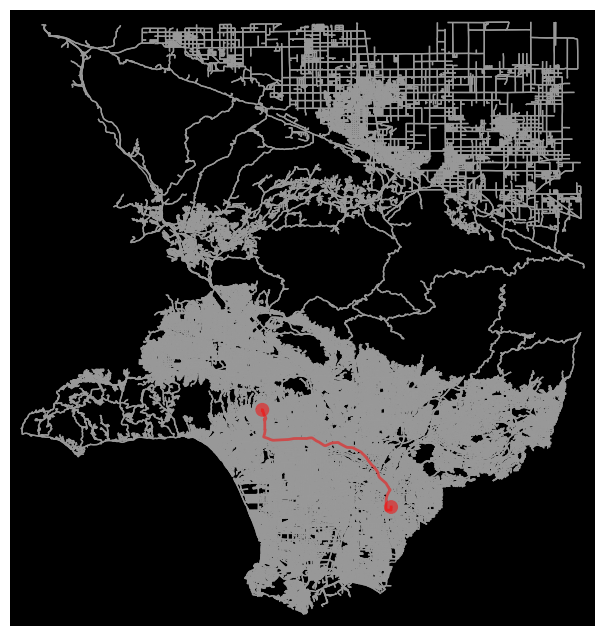

In [34]:
# visualize
fig, ax = ox.plot_graph_route(G, shortest_path, route_linewidth=2, node_size=0, bgcolor='k')

In [35]:
# without traffic or turn penalties
# weight = 'travel_time'
no_penalty = shortest_path_turn_penalty(G, orig_node, dest_node, weight='travel_time')

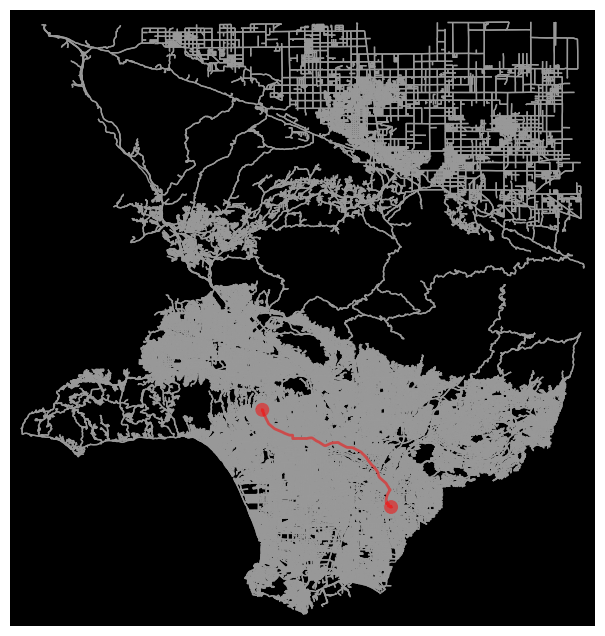

In [36]:
# visualize
fig, ax = ox.plot_graph_route(G, no_penalty, route_linewidth=2, node_size=0, bgcolor='k')

In [37]:
# only traffic penalties
only_traffic = shortest_path_turn_penalty(G, orig_node, dest_node, weight='total_time')

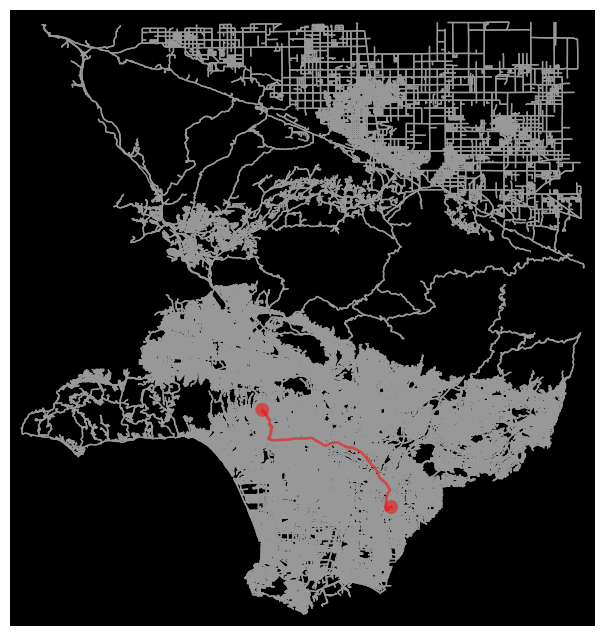

In [38]:
# visualize
fig, ax = ox.plot_graph_route(G, only_traffic, route_linewidth=2, node_size=0, bgcolor='k')

In [75]:
# only turn penalties
only_turn = shortest_path_turn_penalty(G, orig_node, dest_node, weight='travel_time', penalty=penalty)

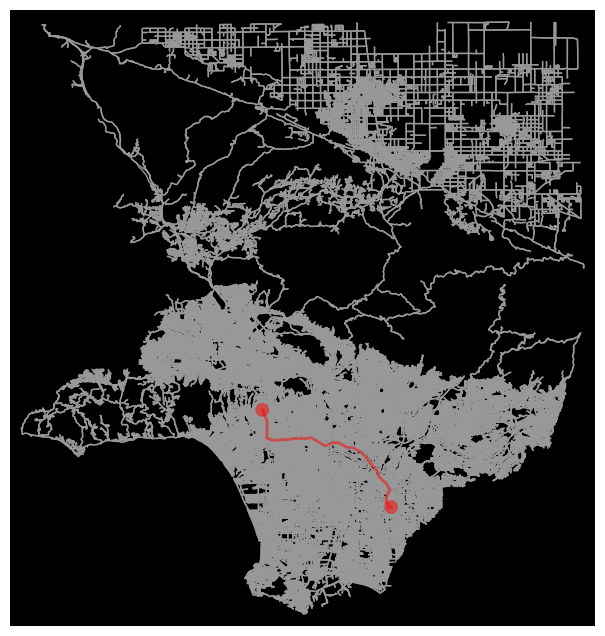

In [76]:
# visualize
fig, ax = ox.plot_graph_route(G, only_turn, route_linewidth=2, node_size=0, bgcolor='k')

# Calculate time

In [94]:
# calculate the total travel time of each route
no_penalties = sum(ox.utils_graph.get_route_edge_attributes(G, no_penalty, 'travel_time'))
all_penalties = sum(ox.utils_graph.get_route_edge_attributes(G, shortest_path, 'total_time'))
traffic_penalties = sum(ox.utils_graph.get_route_edge_attributes(G, only_traffic, 'total_time'))
turn_penalites = sum(ox.utils_graph.get_route_edge_attributes(G, only_turn, 'travel_time'))

In [96]:
osmnx = ox.distance.shortest_path(G, orig_node, dest_node, weight='travel_time')
osmnx_result = sum(ox.utils_graph.get_route_edge_attributes(G,osmnx, 'travel_time'))

In [102]:
data = {
    'osmnx_result': [osmnx_result],
    'no_penalties': [no_penalties],
    'all_penalties': [all_penalties],
    'traffic_penalties': [traffic_penalties],
    'turn_penalites': [turn_penalites]
}

comparison = pd.DataFrame(data)

In [103]:
comparison

,osmnx_result,no_penalties,all_penalties,traffic_penalties,turn_penalites
0,1749.3,1749.3,2621.2,2353.1,1778.9
